In [1]:
# import dependencies

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import torchsummary
import torchvision

In [3]:
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Define the Generator and Discriminator

We use the architecture suggested by [MMD GAN: Towards Deeper Understanding of Moment Matching Network](https://arxiv.org/abs/1705.08584), with the [DCGAN architecture](https://arxiv.org/pdf/1511.06434).

### Defining first the encoder and decoder

We use the encoder and decoder to define our generator and discriminator. The encoder is the first part of the discriminator, and the decoder is the last part of the generator. The encoder is used to extract features from the input data, and the decoder is used to generate data from the features. The encoder and decoder are used to define the generator and discriminator, respectively.

In [51]:
nz = 10
ngf = 64 # number of generator filters
ndf = 64 # number of discriminator filters
nc = 1 # number of channels

# define the encoder and decoder from the DCGAN architecture
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, nc=1, ndf=64, k=100):
        super(Encoder, self).__init__()
        # Simplified sequential model without checks for image size
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # initial layer
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 10, 3, 1, 0, bias=False)  # final layer to 1 x 1 x k
        )

    def forward(self, input):
        return self.main(input)

# class Decoder(nn.Module):
#     def __init__(self, nc, ngf=64, k=100):
#         super(Decoder, self).__init__()
#         # Simplified sequential model without loops for dynamic layer creation
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(k, ngf * 4, 4, 1, 0, bias=False),  # starting from a small spatial extent
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # up to the original image size
#             nn.Tanh()
#         )
# 
#     def forward(self, input):
#         return self.main(input)

class Decoder(nn.Module):
    def __init__(self, nc, ngf=64, k=10):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            # First layers to upscale from latent size to a smaller feature map
            nn.ConvTranspose2d(k, ngf * 4, 4, 1, 0, bias=False),  # input 10*1*1, output 256*4*4
            nn.BatchNorm2d(ngf * 4), # BatchNorm2d(256)
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # Middle size, input 256*4*4, output 128*8*8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # Nearing target size, input 128*8*8, output 64*16*16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 3, bias=False),  # Adjust padding here
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [52]:
# test the dimension of the encoder and decoder
encoder = Encoder(nc=nc, ndf=ndf, k=nz).to(device)
decoder = Decoder(nc=nc, ngf=ngf, k=nz).to(device)

# test the encoder
x = torch.randn(1,1,28,28).to(device)
print("Input shape:", x.shape)
print("Output shape:", encoder(x).shape)

# test the decoder
x = torch.randn(1,nz,1,1).to(device)
print("Input shape:", x.shape)
print("Output shape:", decoder(x).shape)

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10, 1, 1])
Input shape: torch.Size([1, 10, 1, 1])
Output shape: torch.Size([1, 1, 28, 28])


In [53]:
# define generator and discriminator using encoder and decoder
class Generator(nn.Module):
    def __init__(self, decoder):
        super(Generator, self).__init__()
        self.decoder = decoder

    def forward(self, input):
        return self.decoder(input)

class Discriminator(nn.Module):
    def __init__(self, encoder, decoder):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        # Encoding the input
        f_enc_X = self.encoder(input)
        # Decoding the encoded features
        f_dec_X = self.decoder(f_enc_X)

        # Flatten the features for potential loss calculations or further processing
        f_enc_X = f_enc_X.view(input.size(0), -1)
        f_dec_X = f_dec_X.view(input.size(0), -1)

        return f_enc_X, f_dec_X


In [54]:
# dimension check using torch summary
# Create some generator and discriminator

encoder = Encoder(nc=nc, ndf=ndf, k=nz).to(device)
decoder = Decoder(nc=nc, ngf=ngf, k=nz).to(device)

netG = Generator(decoder).to(device)
netD = Discriminator(encoder, decoder).to(device)

torchsummary.summary(netG, input_size=(nz,1,1))
torchsummary.summary(netD, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]          40,960
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,024
             Tanh-11            [-1, 1, 28, 28]               0
          Decoder-12            [-1, 1, 28, 28]               0
Total params: 698,240
Trainable params: 698,240
Non-trainable params: 0
-------------------------------

In [55]:
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

Weight initialization

In [56]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

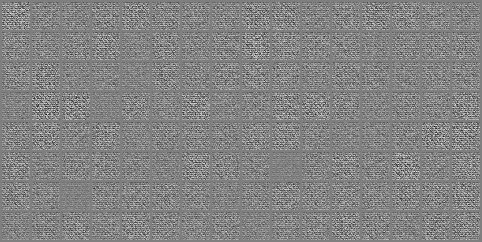

In [57]:
# Create the generator and discriminator
encoder = Encoder(nc=nc, ndf=ndf, k=nz).to(device)
decoder = Decoder(nc=nc, ngf=ngf, k=nz).to(device)

netG = Generator(decoder).to(device)
netD = Discriminator(encoder, decoder).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
netG.apply(weights_init)
netD.apply(weights_init)

show(netG, nz=10);

## MMD for rbf Kernel


We code the $MMD^2$ function, assuming that the numbers of example in X and Y are the same.

We use the equation provided in the paper [DEMYSTIFYING MMD GANS](https://openreview.net/pdf?id=r1lUOzWCW), and code inspired from the repository.


In [58]:
def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    """
    input: 
    """
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2

In [59]:
def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0)) # assuming that the number of examples in X and Y are the same
    m = X.size(0)

    Z = torch.cat((X, Y), 0) # concatenate the two tensors along the first dimension
    ZZT = torch.mm(Z, Z.t()) # matrix multiplication
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t() # it is the same as ||x - y||^2

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)

In [60]:
def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

# Get my MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [61]:
from torchvision.datasets import MNIST
import torch.utils.data as data

In [62]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/9CVqJA4ucX/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/9CVqJA4ucX/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/9CVqJA4ucX/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/9CVqJA4ucX/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/9CVqJA4ucX/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/9CVqJA4ucX/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting /tmp/9CVqJA4ucX/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/9CVqJA4ucX/MNIST/raw


torch.Size([128, 1, 28, 28])


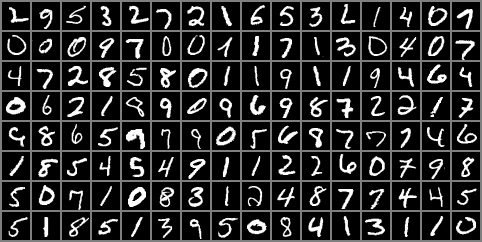

In [63]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

# Writing the Training loop

In [75]:
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(42)
# hyperparameters
lr = 0.0002
beta1 = 0.5
epochs = 10
nz = 10
sigma_list = [0.1, 1.0, 10.0]

# initialize the generator and discriminator
encoder = Encoder(nc=nc, ndf=ndf, k=nz).to(device)
decoder = Decoder(nc=nc, ngf=ngf, k=nz).to(device)
decoder2 = Decoder(nc=nc, ngf=ngf, k=nz).to(device)

G = Generator(decoder).to(device)
D = Discriminator(encoder, decoder2).to(device)

# optimizer
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(epochs):
    for i, (real, _) in enumerate(train_loader):
        for p in D.parameters():
            p.requires_grad = True
        
        # clipping the parameters of the discriminator
        for p in D.encoder.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        real = real.to(device)
        batch_size = real.size(0)

        # noise
        noise = torch.randn(batch_size, nz, 1, 1).to(device)
        
        ## ----- update D network ----- ##
        # zero the gradients
        optimizerD.zero_grad()
        
        fake_images = G(noise)
        # print the size
        # print("fake_image shape:", fake_image.shape)
        # print("real shape:", real.shape)

        # Discriminator loss
        f_enc_real, f_dec_real = D(real)
        f_enc_fake, f_dec_fake = D(fake_images.detach())
        
        # print("f_enc_real shape:", f_enc_real.shape)
        # print("f_enc_fake shape:", f_enc_fake.shape)

        # Compute the MMD
        loss_mmd_D = mix_rbf_mmd2(f_enc_real, f_enc_fake, sigma_list)

        # Backpropagate the gradients
        loss_mmd_D.backward()
        optimizerD.step()
        
        ## ----- update G network ----- ##
        for p in D.parameters():
            p.requires_grad = False
            
        # zero the gradients
        optimizerG.zero_grad()
        # optimizerD.zero_grad()
        
        fake_images = G(noise)

        # Generator loss
        f_enc_fake, f_dec_fake = D(fake_images)

        # Compute the MMD
        loss_mmd_G = mix_rbf_mmd2(f_enc_real, f_enc_fake, sigma_list)

        # Backpropagate the gradients
        loss_mmd_G.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}] Batch {i}/{len(train_loader)} \
                    Loss D: {loss_mmd_D.item()} Loss G: {loss_mmd_G.item()}')
            
    show(G)

/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/infres/fhong-22/anaconda3/envs/ima-env-new/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/inf

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.